In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 폰트
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프 마이너스 폰트 깨지는 문제 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import mglearn

- 특성이 추가되면 모델은 더 복잡해지고 과대적합될 가능성도 높아짐
- 새로운 특성을 추가할 때 or 고차원 데이터셋을 이용할 때 -> 가장 유용한 특성만 선택하고, 나머지는 무시해서 특성의 수를 줄이는 것이 좋음
-> 모델이 간단해지고, 일반화 성능이 올라감
- 이를 위한 방법 3가지
    1. 일변량 통계
    2. 모델 기반 선택
    3. 반복적 선택
- 모두 지도 학습 방법 -> 최적값을 찾으려면, 타깃값이 필요. 훈련 데이터(train set)만 특성 선택에 사용해야함(테스트 세트의 정보 누설 방지)

# 일변량 통계
- 개개의 특성과 타깃 사이에 중요한 통계적 관계가 있는지 계산 -> 타깃과 깊게 관련되어 있다고 판단되는 특성 선택
    - **일변량: 각 특성이 독립적으로 평가됨**
    - 다른 특성과 깊게 연관된 특성은 선택되지 않을 것
    - 계산 빠름, 평가를 위해 모델 만들 필요 X, 모델에 상관없이 사용 가능
- scikit-learn.feature_selection
    - 매우 높은 p-값을 가진 특성을 제외할 수 있도록 임계값 조정 매개변수
        - SelectKBest: 고정된 k개의 특성 선택
        - SelectPercentile: 지정된 비율만큼 특성 선택
    - 특성 선택하는 기준은 F-값. 값이 클 수록 클래스 평균의 분산이 비교적 크다는 것을 나타냄
    - fit 메서드에서 train set으로 통계값 계산
    - transform 메서드에서 train set, test set의 특성을 선택함
- 분류
    - 분산분석(ANOVA) 개념
        - 데이터를 클래스별로 나누어 평균을 비교하는 방법
        - 분산분석으로 계산한 어떤 특성의 F-값이 높으면, 그 특성은 클래서별 평균이 서로 다르다는 뜻
    - f_classif(기본값)
        - 클래스별 분산을 전체 분산에서 클래스별 평균 분산을 뺀 값으로 나누어 F-값 계산
    - chi2(카이제곱 옵션)
- 회귀
    - f_regression
        - 각 특성의 상관계수를 계산하고, 이를 이용해 F-값과 p-value 계산


In [28]:
# cancer data set에 분류를 위한 특성 선택 적용
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# 데이터에 noise 특성 추가
# 고정된 난수 발생 시키기
# 처음 30개는 원본 특성, 다음 50개는 노이즈 특성
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
X_w_noise = np.hstack([cancer.data, noise])   # np.hstack: 옆으로, 열 합치는 함수

# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

# f_classif(기본값)와 SelectPercentile을 사용하여 특성의 50% 선택) - train set만 사용!
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

# 훈련 세트에 적용
X_train_selected = select.transform(X_train)

print('X_train.shape', X_train.shape)
print('X_train_selected.shape', X_train_selected.shape)

X_train.shape (284, 80)
X_train_selected.shape (284, 40)


- .get_support
    - 선택된 특성을 불리언 값으로 표시해줌
    - 어떤 특성이 선택되었는지 확인할 수 있음

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([<matplotlib.axis.YTick at 0x164b68fb460>],
 <a list of 1 Text major ticklabel objects>)

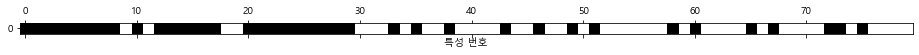

In [29]:
mask = select.get_support()
print(mask)
# True 검은색, False 흰색으로 마스킹
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('특성 번호')
plt.yticks([0])

- 선택된 특성은 대부분 원본 특성(0~30)이고, 노이즈 특성은 거의 선택되지 않아 제거됨
- 그러나 원본 특성이 완변하게 복원된 것은 아님(일부 원본특성 선택 X -> 제거됨)

In [15]:
# 전체 원본 특성 사용 vs 선택된 특성 사용
from sklearn.linear_model import LogisticRegression

# 테스트 데이터 변환
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print('전체 특성을 사용한 점수: {:.3f}'.format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print('선택된 일부 특성을 사용한 점수: {:.3f}'.format(lr.score(X_test_selected, y_test)))

C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


전체 특성을 사용한 점수: 0.937
선택된 일부 특성을 사용한 점수: 0.940


C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 이 경우에는 선택된 일부 특성을 사용했을 때가 성능이 더 높지만, 실제 데이터에서의 결과는 보통 엇갈리는 경우도 많음(전체가 더 높을 수도)
- **너무 많은 특성때문에 모델 만들기가 어려울 때, 많은 특성이 확실히 도움이 안된다고 생각될 때 -> 일변량 분석을 통해 특성 선택을 하면 큰 도움이 됨**

# 모델 기반 특성 선택
- **지도학습 머신러닝 모델을 사용하여, 특성의 중요도 평가 및 가장 중요한 특성들 선택**
- 특성 선택에 사용하는 지도학습 모델을 최종적으로 사용할 모델과 **같을 필요 없음**
- **결정트리와 이를 기반으로 한 모델**
    - 각 특성의 중요도가 담겨있는 feature_importances_ 속성 제공
- **선형 모델 계수의 절댓값**도 특성 중요도 판단하는 데 사용 가능
    - L1 규제를 사용한 선형모델은 일부 특성의 계수만 학습함
    - 그 모델 자체를 위해 특성이 선택된다고 생각할 수 있지만, 다른 모델의 특성 선택을 위해 전처리 단계로도 사용가능!
- 모델기반 특성 선택은 SelectFromModel에 구현됨
    - SelectFromModel은 지도 학습 모델로 계산된 중요도가 지정한 임계치보다 큰 모든 특성을 선택
    - threshold
        - 임계치 기준
        - 기본값 mean, 그외 median, 1.2*median(중간값의 비율), 1.3*mean(평균값의 비율), ...

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
            RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'
)

In [18]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape', X_train.shape)
print('X_train_1l.shape:',X_train_l1.shape)

X_train.shape (284, 80)
X_train_1l.shape: (284, 40)


- 중앙값을 임계치로 사용했기때문에 80 -> 40개로 특성 50% 줄어듬

Text(0.5, 0, '특성 번호')

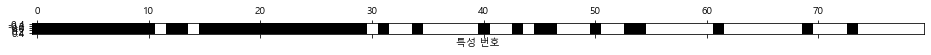

In [19]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('특성 번호')

- 2개를 제외한 모든 원본 특성 선택 + 일부 noise특성 선택됨

In [21]:
# 성능 확인
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=1000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('테스트 점수:{:.3f}', format(score))

테스트 점수:{:.3f} 0.9508771929824561


C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 일변량 특성 선택보다 특성 선택이 더 잘되어, 성능도 조금 향상됨

# 반복적 특성 선택
- 특성의 수가 각기 다른 일련의 모델이 생성됨
- 모델이 만들어지기 때문에 다른 방법보다 계산 비용이 많이듬
- 방법 
    1. 전진 선택법
        - 특성을 하나도 선택하지 않은 상태로 시작해서, 어떤 종료 조건에 도달할 때까지 하나씩 **추가**
    2. 후진 선택법
        - 모든 특성을 가지고 시작해서, 어떤 종료 조건이 될 때까지 특성을 하나씩 **제거**
- 재귀적 특성 제거(RFE)가 이런 방법의 하나
    - 모든 특성으로 시작해서 모델을 만들고, 특성 중요도가 가장 낮은 특성을 제거(특성 1개씩 제거됨)
    - 그 다음 제거한 특성을 빼고 나머지 특성 전체로 새로운 모델을 만듬
    - 미리 정의한 특성 개수가 남을 때까지 계속 반복됨
- 특성 선택에 사용할 모델은 특성의 중요도를 결정하는 방법을 제공해야함

Text(0.5, 0, '특성 번호')

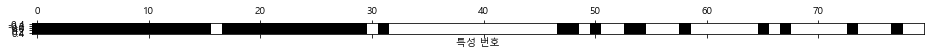

In [23]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)  # 40개 특성 남도록

select.fit(X_train, y_train)

# 선택된 특성 표시
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('특성 번호')

- 일변량 분석이나 모델 기반 선택보다 특성 선택이 나아졌지만, 여전히 원본 특성 한개를 놓치고있음
- 특성이 누락될 때마다 다시 학습하므로 40번이나 실행됨(시간 다소 소요됨)

In [25]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=1000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('테스트 점수: {:.3f}'.format(score))

테스트 점수: 0.954


C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
# rfe에 사용된 모델을 이용해 예측 가능 - 선택된 특성만 사용하여
print('테스트 점수: {:.3f}'.format(select.score(X_test, y_test)))

테스트 점수: 0.951


- rfe안에 있는 랜덤 포레스트의 성능이, 이 모델에서 선택한 특성으로 만든 로지스틱 회귀의 성능과 비슷함
    - 특성 선택이 제대로 되면, 선형 모델의 성능은 랜덤 포레스트와 견줄만 함!

# 전문가 지식 활용(도메인 지식)
- 더 유용한 특성을 선택할 수 있도록 도움
    - ex. 항공료 예측에 공휴일, 방학 전후 등의 특성 추가
- 특성이 추가된다고 머신러닝 알고리즘이 반드시 그 특성을 사용하는 것은 아님

## 예제 - 자전거 대여 예측

In [3]:
# 시티 바이크 데이터 - 2015.8 data (3시간마다 누적)
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

Text(0, 0.5, '대여 횟수')

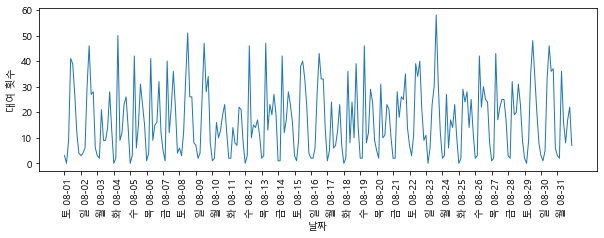

In [6]:
# 8월 한 달 동안의 대여 횟수
plt.figure(figsize=(10,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')   # x축 범위
week = ['일','월','화','수','목','금','토']
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime('%w'), xticks.strftime(' %m-%d'))]
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('날짜')
plt.ylabel('대여 횟수')

- 24시간 간격으로 낮과 밤의 차이, 주중과 주말의 패턴 차이 등이 보임

In [7]:
# 타깃값 추출(대여 횟수)
y = citibike.values
# POSIX 시간을 10**9로 나누어 변환   # 1970.01.01 00:00:00부터 경과한 시간(초)
X = citibike.index.astype('int64').values.reshape(-1,1) // 10**9

In [11]:
y

array([ 3,  0,  9, 41, 39, 27, 12,  4,  3,  4,  6, 30, 46, 27, 28,  6,  3,
        2, 21,  9,  9, 14, 28, 13,  0,  2, 50,  9, 12, 23, 26, 14,  0,  3,
       42,  6, 15, 31, 23, 15,  1,  4, 41,  9, 15, 16, 32, 12,  5,  1, 40,
       12, 22, 36, 22,  4,  6,  3, 12, 33, 51, 26, 26,  8,  7,  2,  4, 26,
       47, 28, 34,  8,  1,  2, 16, 10, 13, 19, 23, 12,  2,  2, 14,  8,  7,
       22, 21,  8,  0,  3, 46, 10, 15, 14, 17, 11,  2,  3, 47, 13, 23, 19,
       27, 19,  1,  1, 42, 12, 17, 28, 23, 16,  3,  1,  9, 38, 40, 33, 22,
        4,  2,  2,  6, 27, 43, 33, 33, 13,  1,  5, 24,  6,  7, 13, 23,  7,
        0,  2, 36,  8, 24, 10, 39, 14,  2,  2, 46,  8, 12, 29, 24,  9,  5,
        2, 31, 10, 11, 23, 21, 10,  2,  2, 28, 18, 26, 25, 35, 14,  7,  3,
       11, 39, 34, 40, 21,  9, 11,  0,  6, 23, 30, 58, 31, 12,  2,  3, 27,
        6, 17, 14, 23, 10,  0,  2, 29, 24, 28, 14, 25, 12,  2,  3, 42, 22,
       30, 25, 24,  8,  1,  2, 43, 17, 22, 25, 25, 17,  3,  2, 32, 19, 20,
       31, 23,  9,  2,  0

In [12]:
X

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400],
       [1438495200],
       [1438506000],
       [1438516800],
       [1438527600],
       [1438538400],
       [1438549200],
       [1438560000],
       [1438570800],
       [1438581600],
       [1438592400],
       [1438603200],
       [1438614000],
       [1438624800],
       [1438635600],
       [1438646400],
       [1438657200],
       [1438668000],
       [1438678800],
       [1438689600],
       [1438700400],
       [1438711200],
       [1438722000],
       [1438732800],
       [1438743600],
       [1438754400],
       [1438765200],
       [1438776000],
       [1438786800],
       [1438797600],
       [1438808400],
       [1438819200],
       [1438830000],
       [1438840800],
       [1438851600],
       [1438862400],
       [1438873200],
       [1438884000],
       [14388

In [14]:
# 처음 184개 데이터 포인트를 훈련 세트로 사용하고 나머지는 테스트 세트로 사용
n_train = 184

# 주어진 특성을 사용하여 평가 및 시각화
def eval_on_features(features, target, regressor):
    # train, test set 나누기
    X_train, X_test = features[:n_train], features[n_train:]
    # 타깃값 y도 나누기
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print('테스트 세트 R^2:{:.2f}'.format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)   # test set 예측값
    y_pred_train = regressor.predict(X_train)   # train set 예측값
    
    plt.figure(figsize=(10,3))
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train, len(y_test)+n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='테스트 예측')
    plt.legend(loc=(1.01,0))
    plt.xlabel('날짜')
    plt.ylabel('대여 횟수')

테스트 세트 R^2:-0.04


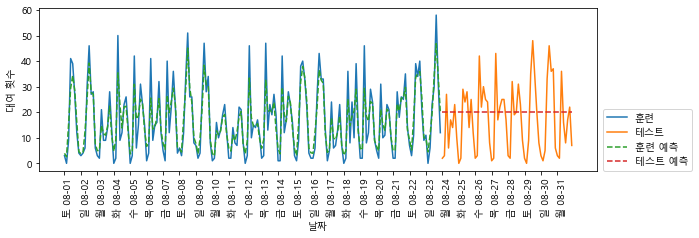

In [16]:
# 랜덤 포레스트 - 데이터 전처리 거의 필요하지 않아 맨 처음 시도하기 좋음
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

- 훈련 예측은 매우 정확하나, 테스트 세트 예측 일직선(한가지 값으로만 예측함)
- 랜덤 포레스트는 훈련세트에 있는 특성의 범위 밖으로 외삽할 수 있는 능력이 없어, 마지막 훈련 세트 데이터의 타깃값을 예측으로 사용함
    - POSIX 시간 특성의 값은 훈련 세트에 있는 특성 값의 범위 벗어남

테스트 세트 R^2:0.60


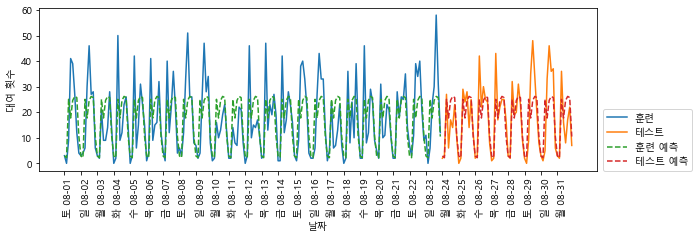

In [17]:
X_hour = citibike.index.hour.values.reshape(-1,1)   # POSIX 특성 버리고, 시간 특성 사용
eval_on_features(X_hour, y, regressor)

- 훨씬 나아졌지만, 주간 패턴은 예측 못함

테스트 세트 R^2:0.84


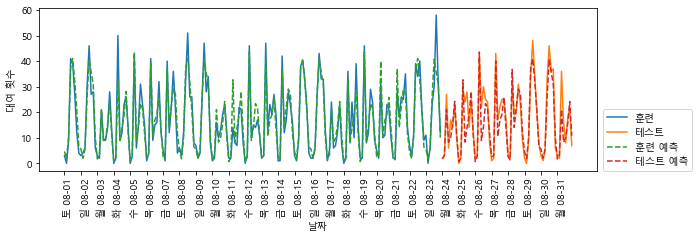

In [20]:
# 요일 특성도 추가 -> 특성 총 2개(시간, 요일)
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1,1), citibike.index.hour.values.reshape(-1,1)])
eval_on_features(X_hour_week, y, regressor)

- 하루 시간과 요일에 따른 패턴을 어느정도 따르고 있음. 성능 더 향상됨

In [22]:
X_hour_week

array([[ 5,  0],
       [ 5,  3],
       [ 5,  6],
       [ 5,  9],
       [ 5, 12],
       [ 5, 15],
       [ 5, 18],
       [ 5, 21],
       [ 6,  0],
       [ 6,  3],
       [ 6,  6],
       [ 6,  9],
       [ 6, 12],
       [ 6, 15],
       [ 6, 18],
       [ 6, 21],
       [ 0,  0],
       [ 0,  3],
       [ 0,  6],
       [ 0,  9],
       [ 0, 12],
       [ 0, 15],
       [ 0, 18],
       [ 0, 21],
       [ 1,  0],
       [ 1,  3],
       [ 1,  6],
       [ 1,  9],
       [ 1, 12],
       [ 1, 15],
       [ 1, 18],
       [ 1, 21],
       [ 2,  0],
       [ 2,  3],
       [ 2,  6],
       [ 2,  9],
       [ 2, 12],
       [ 2, 15],
       [ 2, 18],
       [ 2, 21],
       [ 3,  0],
       [ 3,  3],
       [ 3,  6],
       [ 3,  9],
       [ 3, 12],
       [ 3, 15],
       [ 3, 18],
       [ 3, 21],
       [ 4,  0],
       [ 4,  3],
       [ 4,  6],
       [ 4,  9],
       [ 4, 12],
       [ 4, 15],
       [ 4, 18],
       [ 4, 21],
       [ 5,  0],
       [ 5,  3],
       [ 5,  6

테스트 세트 R^2:0.13


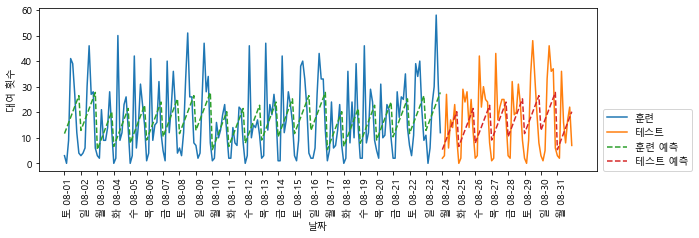

In [21]:
# 선형회귀적용
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

- 요일과 시간이 정수로 인코딩 되어있어, 연속형 변수로 인식하여 성능 안좋게 나옴 => 범주형 변수로 변환 필요!

In [24]:
# 원핫인코딩으로 변환
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [25]:
X_hour_week_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

테스트 세트 R^2:0.62


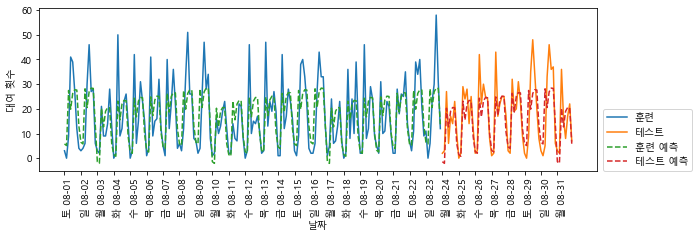

In [27]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot, y, Ridge())

- 연속형 특성일 때보다 훨씬 성능 향상됨

테스트 세트 R^2:0.85


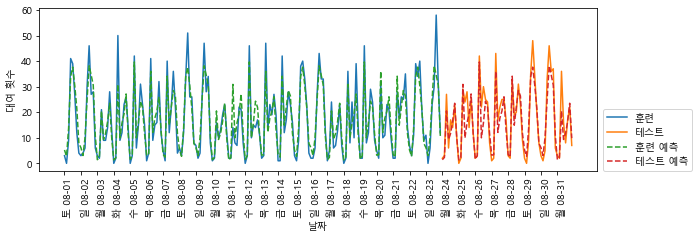

In [28]:
# 상호작용 특성 사용
from sklearn.preprocessing import PolynomialFeatures

# 시간과 요일의 곱특성 추가
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)   # 2차 다항식까지
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

Text(0, 0.5, '계수 크기')

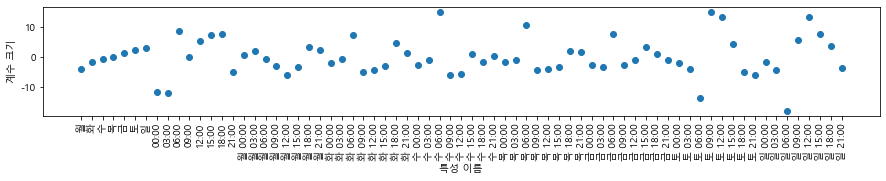

In [32]:
# 모델이 학습한 계수 시각화

# 1. 시간, 요일 특성의 이름 짓기
hour = ['%02d:00' % i for i in range(0,24,3)]
day = ['월','화','수','목','금','토','일']
features = day + hour

# 2. get_feuature_names 메서드를 사용해, 모든 상호작용 특성이 이름 달기
features_poly = poly_transformer.get_feature_names(features)
# 계수가 0이 아닌 특성만 선택
features_nonzero = np.array(features_poly)[lr.coef_ != 0]   
coef_nonzero = lr.coef_[lr.coef_ != 0]

# 3. 선형모델에서 학습한 계수 시각화(0인 특성 제외됨)
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('특성 이름')
plt.ylabel('계수 크기')